In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from modules import torch_classes
from torchvision import transforms, utils
from modules.grad_cam_new import *
#from modules.grad_cam import *
import matplotlib as mpl
from tqdm import tqdm

print(mpl.rcParams["image.cmap"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

viridis
cuda:0


In [2]:
net = torch_classes.Net(num_of_classes=33)

#Load trained network weights.
net.load_state_dict(torch.load('CV_file/es_weights/final_weights.pt'))

net.to(device)
net.double()
net.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [3]:
#Train set
labels_path = '../DATA/train_labels.pkl'
data_path = 'train.dat'
data_dims = (8269,10404)
genes_path = 'train.csv'

#Data and labels
train = torch_classes.TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([torch_classes.ToImage(),torch_classes.ToTensor()]))

#Test set
labels_path = '../DATA/test_labels.pkl'
data_path = 'test.dat'
data_dims = (2085,10404)
genes_path = 'test.csv'

test = torch_classes.TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([torch_classes.ToImage(),torch_classes.ToTensor()]))

In [4]:
cancer_names = [['ACC', '79'],
['BLCA', '408'],
['BRCA', '1100'],
['CESC', '306'],
['CHOL', '36'],
['COAD', '478'],
['DLBC', '48'],
['ESCA', '185'],
['GBM', '166'],
['HNSC', '522'],
['KICH', '66'],
['KIRC', '534'],
['KIRP', '291'],
['LAML', '173'],
['LGG', '530'],
['LIHC', '373'],
['LUAD', '517'],
['LUSC', '501'],
['MESO', '87'],
['OV', '307'],
['PAAD', '179'],
['PCPG', '184'],
['PRAD', '498'],
['READ', '167'],
['SARC', '263'],
['SKCM', '472'],
['STAD', '415'],
['TGCT', '156'],
['THCA', '509'],
['THYM', '120'],
['UCEC', '547'],
['UCS', '57'],
['UVM', '80']]

In [5]:
classes = range(0,34)

In [6]:
print("Total in class samples")
print(np.sum(test.labels,axis=0)+np.sum(train.labels,axis=0))
trn_class_nums = np.sum(train.labels,axis=0)
tst_class_nums = np.sum(test.labels,axis=0)

Total in class samples
[  79  408 1100  306   36  478   48  185  166  522   66  534  291  173
  530  373  517  501   87  307  179  184  498  167  263  472  415  156
  509  120  547   57   80]


### Average image over train set

In [56]:
#Method to calculate the average image per class
total_samples = 0
avg_class_imgs = []
for i in range(33):
    img = 0
    #labels = 0
    for trn_i in range(total_samples,total_samples+trn_class_nums[i]):
        img = img + train.get_data(trn_i)['data'].numpy()
        #labels = labels + train.get_data(trn_i)['label'].numpy() #Sanity check
    
    #print(labels)
    avg_class_imgs.append(img/trn_class_nums[i])
    total_samples = total_samples + trn_class_nums[i]

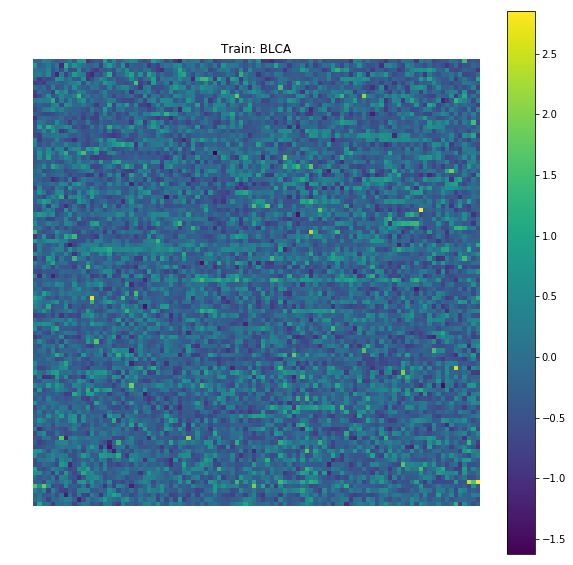

In [148]:
# fig = plt.figure()
# for i, img in enumerate(avg_class_imgs):
#     plt.subplot(11,3,i+1)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.title(cancer_names[i][0])
    
# fig.set_size_inches(20, 80)

j = 1
fig = plt.figure()
plt.imshow(avg_class_imgs[j])
plt.colorbar()
plt.title('Train: '+cancer_names[j][0])
plt.axis('off')
fig.set_size_inches(10,10)

### Saving all average train images

In [147]:
for i, image in enumerate(avg_class_imgs):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Train: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_train/average_train_'+cancer_names[i][0]+'.png')
    plt.close(fig)

### Average image over test set

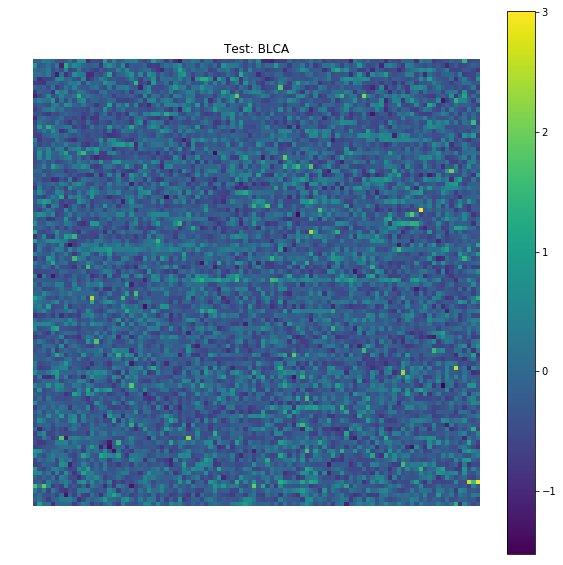

In [149]:
#Method to calculate the average image per class
total_samples = 0
avg_tst_imgs = []
for i in range(33):
    img = 0
    #labels = 0
    for tst_i in range(total_samples,total_samples+tst_class_nums[i]):
        img = img + test.get_data(tst_i)['data'].numpy()
        #labels = labels + test.get_data(tst_i)['label'].numpy() #Sanity check
    
    #print(labels)
    avg_tst_imgs.append(img/tst_class_nums[i])
    total_samples = total_samples + tst_class_nums[i]
    
fig = plt.figure()
plt.imshow(avg_tst_imgs[j])
plt.colorbar()
plt.title('Test: '+cancer_names[j][0])
plt.axis('off')
fig.set_size_inches(10,10)


### Saving all average test images

In [150]:
for i, image in enumerate(avg_tst_imgs):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Test: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_test/average_test_'+cancer_names[i][0]+'.png')
    plt.close(fig)

### NEW Grad-cam library has batch processing for images

In [151]:
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

### Calculating average guided grad-cam map for each class in testing set

In [95]:
tst_class_nums

array([ 16,  82, 220,  62,   8,  96,  10,  37,  34, 105,  14, 107,  59,
        35, 106,  75, 104, 101,  18,  62,  36,  37, 100,  34,  53,  95,
        83,  32, 102,  24, 110,  12,  16])

In [473]:
        im = test.get_data(tst_i)
        image = im['data'].unsqueeze(dim=0).unsqueeze(dim=0)
        image = image.to(device)
        predictions = gcam.forward(image)
        _ = gbp.forward(image)
        top_class = np.argmax(im['label'].numpy())
        #top_class = predictions[0][1]

        #Grad Cam section
        gcam.backward(idx=top_class) #predictions are ordered from most confident to least-> genersting for most confident class
        region = gcam.generate(target_layer=target_layer)

In [ ]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_transparency_blend.html

In [9]:
import time

start = time.time()

target_layer = 'conv3' 
#final convolution layer - best compromise between high-level semantics and detailed spatial information
#but it takes the size of the convolutional filters at that level, hence downsampled image
#hence you use the guided back prop to remap to original space
gcam = GradCAM(model=net)
gbp = GuidedBackPropagation(model=net)

exitFlag = 0
total_samples = 0
avg_cam_maps=[]
for i in range(33):
    running_cam = 0
    for tst_i in tqdm(range(total_samples,total_samples+tst_class_nums[i])):
        im = test.get_data(tst_i)
        image = im['data'].unsqueeze(dim=0).unsqueeze(dim=0)
        image = image.to(device)
        predictions = gcam.forward(image)
        _ = gbp.forward(image)
        top_class = np.argmax(im['label'].numpy())
        #top_class = predictions[0][1]

        #Grad Cam section
        gcam.backward(ids=top_class) #predictions are ordered from most confident to least-> genersting for most confident class
        region = gcam.generate(target_layer=target_layer)

        #guided backprop
        gbp.backward(ids=top_class)
        #gbp.backward(idx=top_class)
        gradient = gbp.generate()

        # Guided Grad-CAM
        h, w, _ = gradient.shape
        region = cv2.resize(region, (w, h))[..., np.newaxis]
        output = (gradient * region).squeeze()

#         fig = plt.figure()
#         plt.imshow(output)
#         plt.colorbar()
#         plt.title('Guided grad-cam: '+cancer_names[i][0])
#         plt.axis('off')
#         fig.set_size_inches(10,10)
#         plt.show()
        
        if (np.isnan(output)).any():
            exitFlag = 1
            print("NAN")
            break
        if (np.isnan(running_cam)).any():
            exitFlag = 1
            print("NAN")
            break

        #Averaging grad-cam maps
        running_cam = running_cam + output

    if exitFlag:
        break
    print("finished class{}".format(i))

    
    avg_cam_maps.append(running_cam/tst_class_nums[i])
    total_samples = total_samples + tst_class_nums[i]
    
print(time.time()-start)

  0%|          | 0/16 [00:00<?, ?it/s]


TypeError: scatter_() received an invalid combination of arguments - got (int, numpy.int64, float), but expected one of:
 * (int dim, Tensor index, Tensor src)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [31;1mnumpy.int64[0m, [31;1mfloat[0m)
 * (int dim, Tensor index, Number value)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [31;1mnumpy.int64[0m, [31;1mfloat[0m)


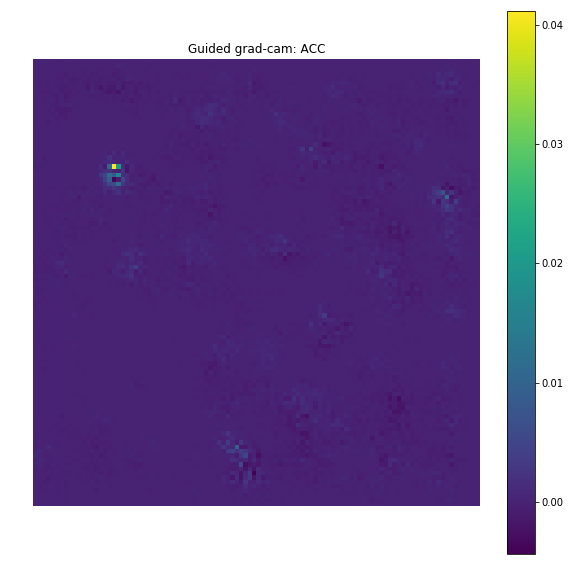

In [445]:
# fig = plt.figure()
# plt.imshow(avg_cam_maps[0])
# plt.colorbar()
# plt.title('Guided grad-cam: '+cancer_names[i][0])
# plt.axis('off')
# fig.set_size_inches(10,10)

### Saving all test cam-maps

In [342]:
for i, image in enumerate(avg_cam_maps):
    fig = plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.title('Guided grad-cam: '+cancer_names[i][0])
    plt.axis('off')
    fig.set_size_inches(10,10)
    fig.savefig('Average_ggcam/average_ggcam'+cancer_names[i][0]+'.png')
    plt.close(fig)

In [439]:
gcam = GradCAM(model=net)
gbp = GuidedBackPropagation(model=net)

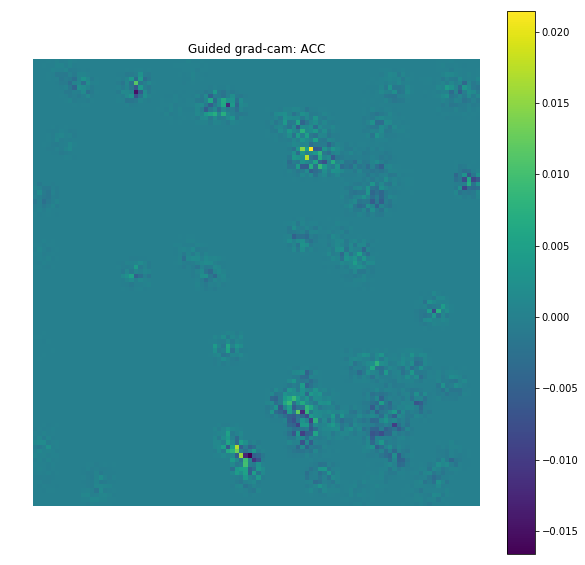

In [442]:
img = test.get_data(0) #get which sample, only call one at a time
image = img['data'].unsqueeze(dim=0).unsqueeze(dim=0)
label = np.argmax(img['label'].cpu().numpy())
image = image.to(device)

#gcam = GradCAM(model=net)
prediction = gcam.forward(image)

#gbp = GuidedBackPropagation(model=net)
_ = gbp.forward(image)

target_layer = 'conv3'

        
# Grad-CAM
gcam.backward(idx=prediction[0][1])
region = gcam.generate(target_layer=target_layer)

# Guided Backpropagation
gbp.backward(idx=prediction[0][1])
gradient = gbp.generate()

# Guided Grad-CAM
h, w, _ = gradient.shape
region = cv2.resize(region, (w, h))[..., np.newaxis]
output = gradient * region

        
fig = plt.figure()
plt.imshow(output.squeeze())
plt.title('Guided grad-cam: '+cancer_names[label][0])

plt.colorbar()
plt.axis('off')
fig.set_size_inches(10,10)


gbp.remove_hook()
gcam.remove_hook()

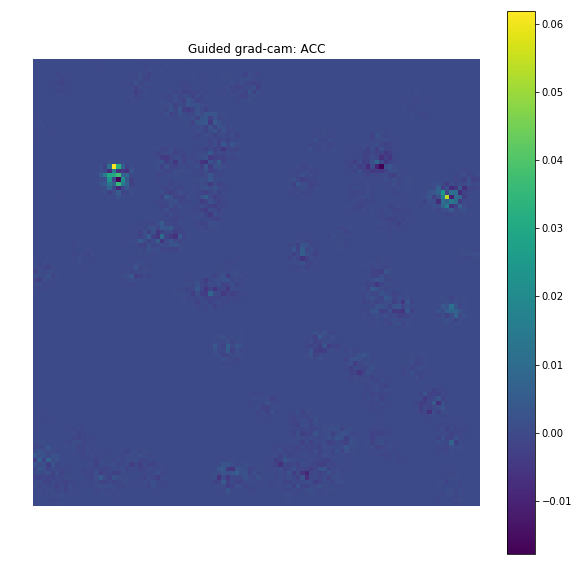

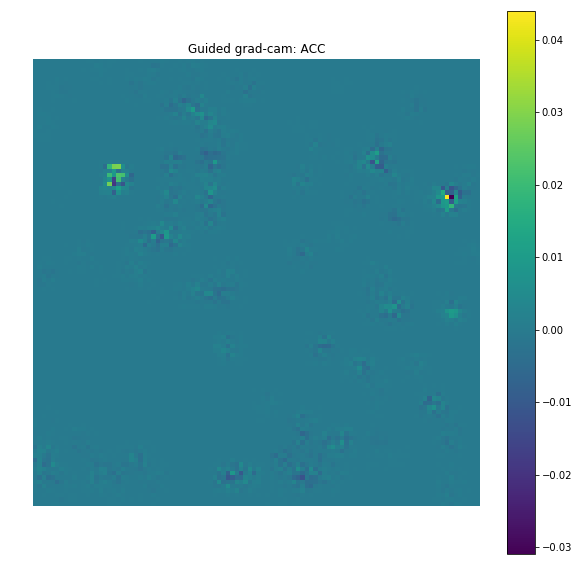

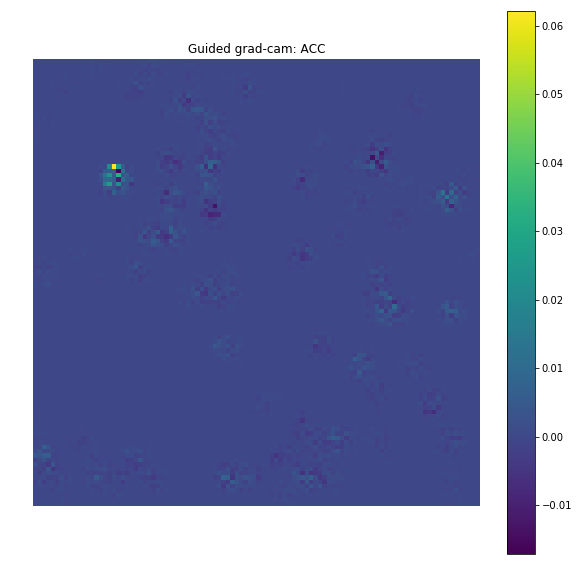

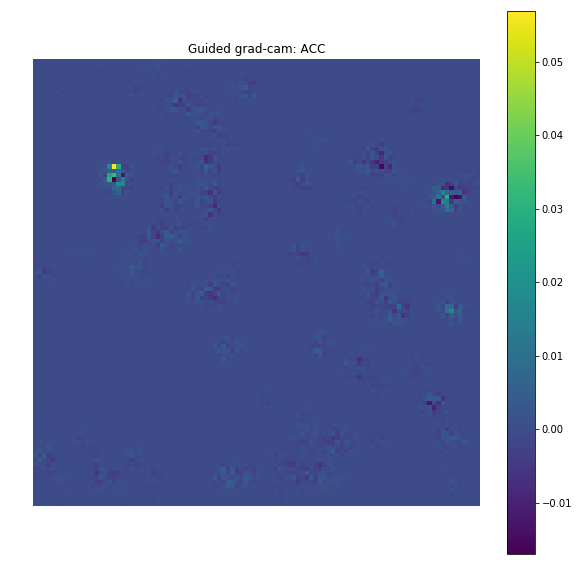

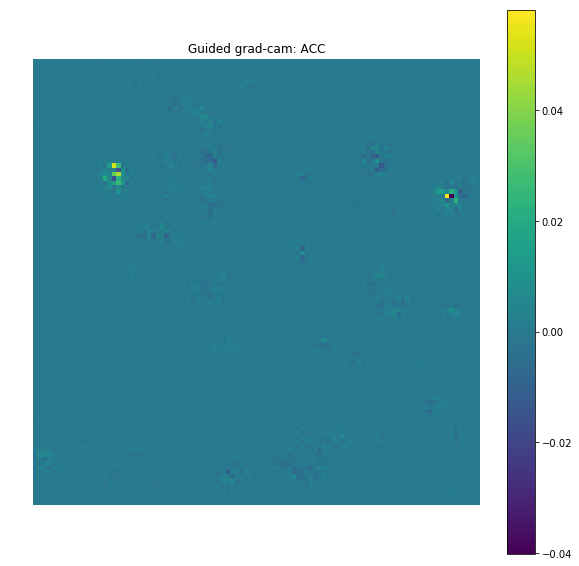

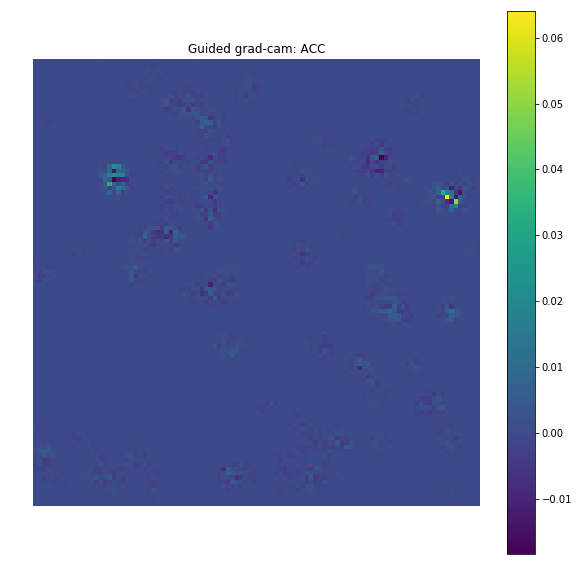

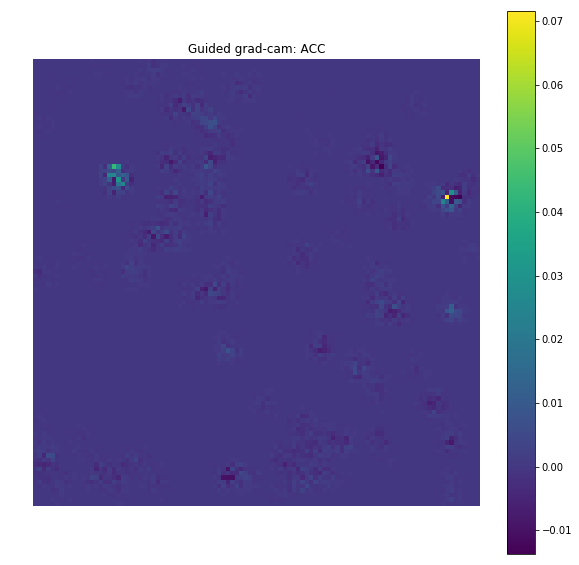

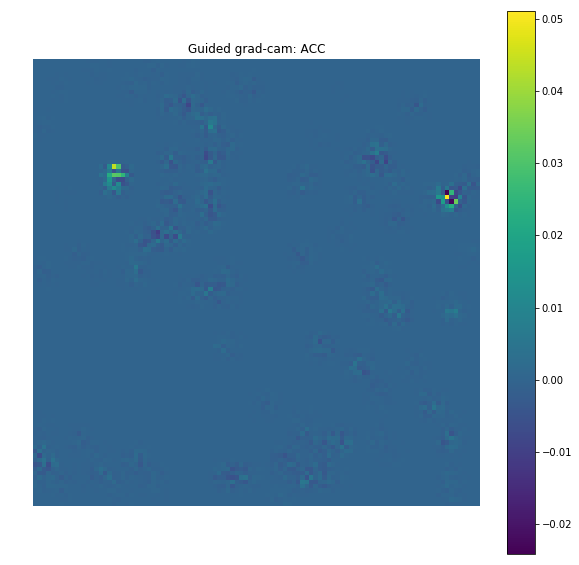

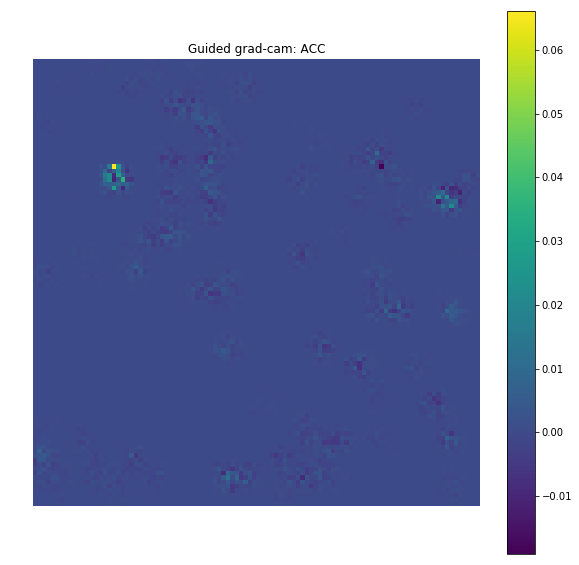

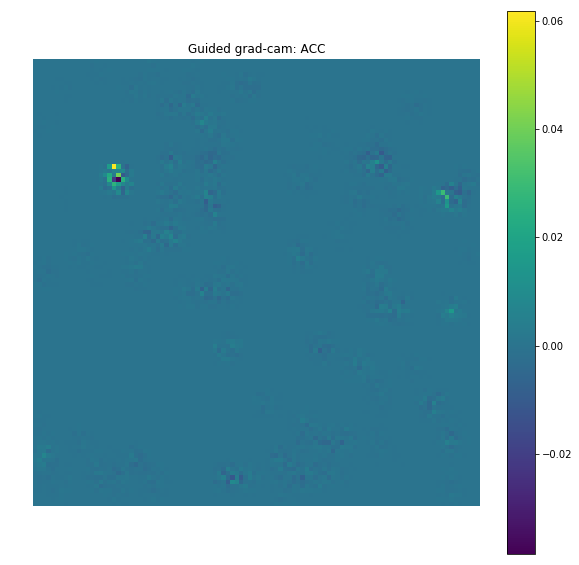

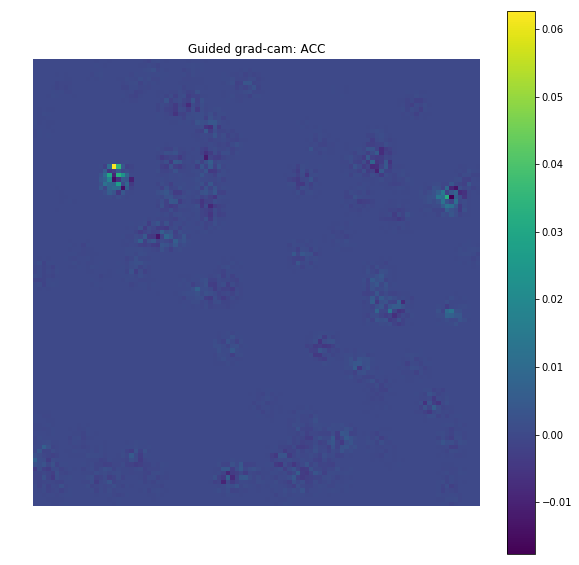

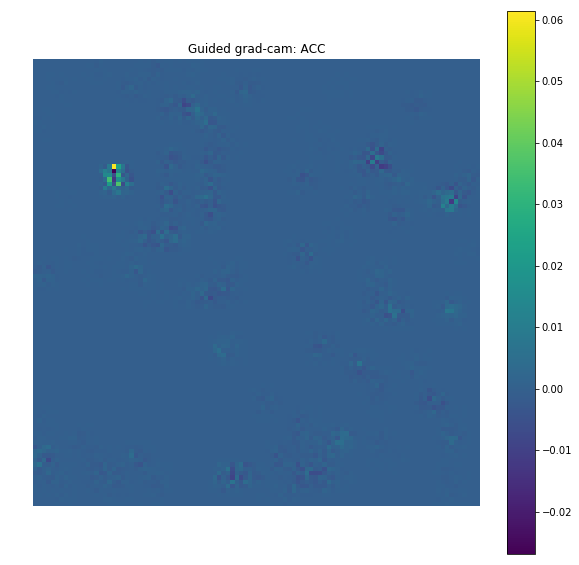

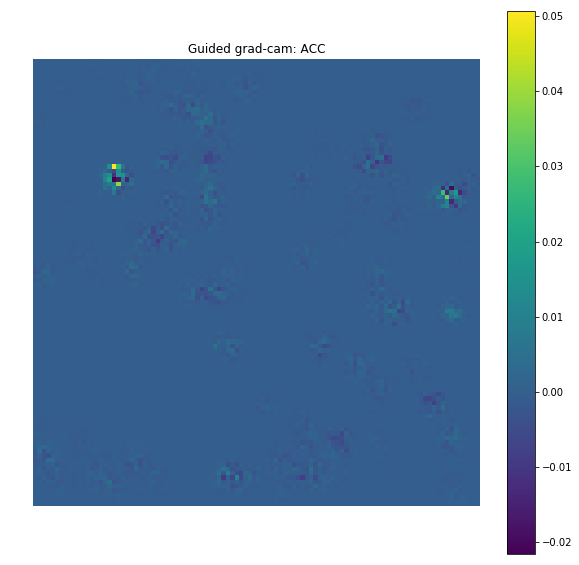

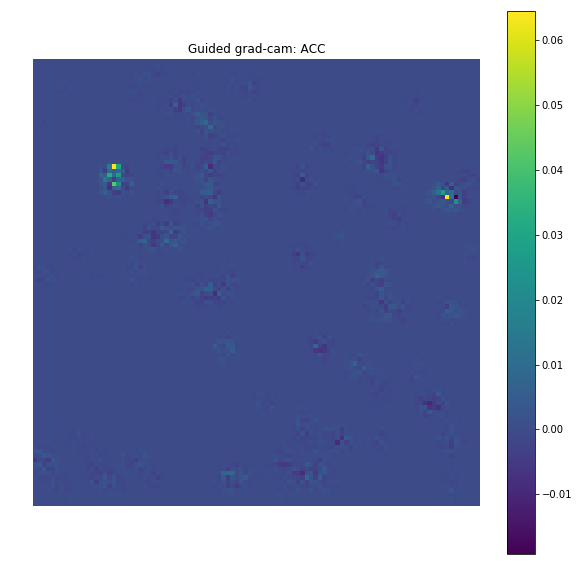

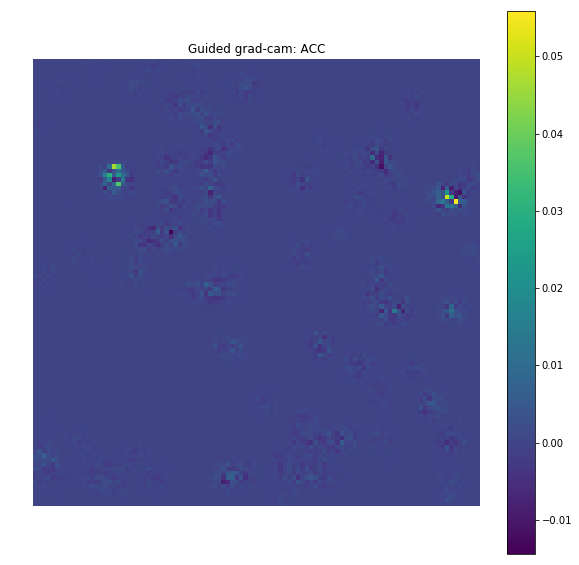

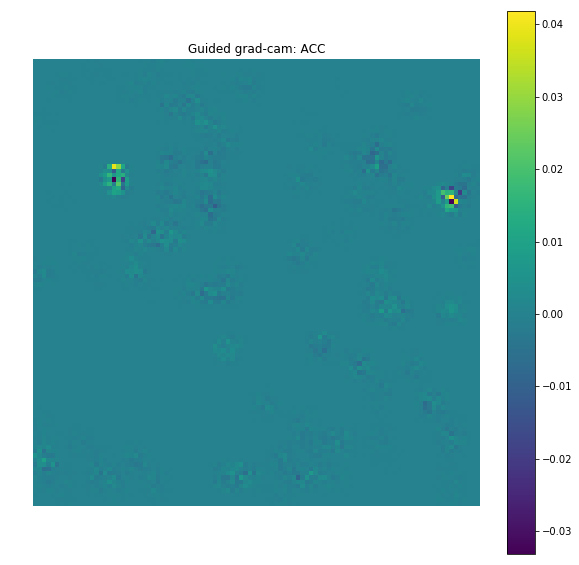

In [111]:
gcam = GradCAM(model=net)
gbp = GuidedBackPropagation(model=net)
for i in range(16):
    img = test.get_data(i) #get which sample, only call one at a time
    image = img['data'].unsqueeze(dim=0).unsqueeze(dim=0)
    label = np.argmax(img['label'].cpu().numpy())
    image = image.to(device)

    prediction = gcam.forward(image)
    _ = gbp.forward(image)

    target_layer = 'conv3'


    # Grad-CAM
    gcam.backward(idx=prediction[0][1])
    region = gcam.generate(target_layer=target_layer)

    # Guided Backpropagation
    gbp.backward(idx=prediction[0][1])
    gradient = gbp.generate()

    # Guided Grad-CAM
    h, w, _ = gradient.shape
    region = cv2.resize(region, (w, h))[..., np.newaxis]
    output = (gradient * region).squeeze()


    fig = plt.figure()
    plt.imshow(output)
    plt.title('Guided grad-cam: '+cancer_names[label][0])

    plt.colorbar()
    plt.axis('off')
    fig.set_size_inches(10,10)
    gbp.remove_hook()
    gcam.remove_hook()